In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from envs import Space
from copy import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
env_config = {'max_step': 100, 'integrator': 'Leapfrog'}
env = Space(env_config)
env.reset()
log = []
done = False
step = 0
while not done:
#     print(step)
    step += 1
    act = np.array([0, 0])
    obs, R, done, _ = env.step(act)
#     print(obs)
    log.append(obs.copy())

/root/hostCurUser/anaconda3/envs/ray/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


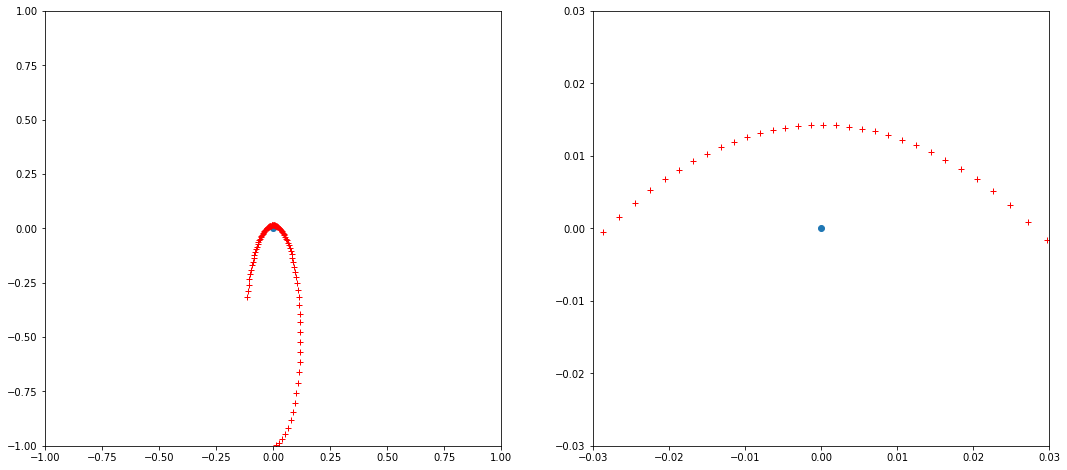

In [62]:
log = np.array(log)
x = log[:, 2]
y = log[:, 3]
# print(x, y)
def plot(ax, x, y, lim=1):
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])
    ax.scatter([0],[0])
    ax.plot(x, y, 'r+')
fig = plt.figure(figsize=(18,8))
plot(fig.add_subplot(121), x, y, 1)
plot(fig.add_subplot(122), x, y, 0.03)